<a href="https://colab.research.google.com/github/Jaderfonseca/youtube-filter-bubbles/blob/main/pipeline_clean_mozilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Filter Bubbles in YouTube Recommendations
**Mini‑project** · Portfolio-ready version

This notebook reproduces the pipeline used to collect a small corpus of YouTube videos by seed queries, build a similarity graph via TF‑IDF, cluster content, and compute simple diversity metrics. It is intentionally compact and reproducible for reviewers.


## How to run
1. Open in Google Colab.
2. Run the **Setup** cell to install packages and securely input your **YouTube Data API v3** key.
3. Execute cells in order: **Data collection → Preprocessing → TF‑IDF & Similarity → Clustering → Metrics → Plots**.
4. Outputs are written to `data/` and figures to `figures/`.


**Folder structure**

- `data/raw/` – raw CSVs from collection
- `data/clean/` – deduplicated & text‑processed CSVs
- `data/processed/` – TF‑IDF, similarity, clustering, metrics
- `figures/` – saved plots


## Setup
Installs minimal dependencies, imports libraries, prompts for the API key via `getpass` (not stored), and creates local folders. This cell must run first.

In [1]:
# --- Setup (safe) ---
# 1) Install minimal dependencies (quiet)
!pip install -q google-api-python-client pandas scikit-learn networkx matplotlib joblib

# 2) Imports
import os, json, math
import pandas as pd
import numpy as np
from getpass import getpass
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 3) Read API key securely (user pastes when prompted)
API_KEY = getpass("Paste your YouTube API key (input is hidden): ").strip()
assert API_KEY, "Empty API_KEY"

# 4) Create local folders (Colab's ephemeral FS)
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/clean", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("figures", exist_ok=True)

print("Environment ready. Proceed cell-by-cell from data collection to plots.")


Paste your YouTube API key (input is hidden): ··········
Environment ready. Proceed cell-by-cell from data collection to plots.


In [19]:
import requests
import pandas as pd

API_KEY = API_KEY  # reuse your existing key variable
SEARCH_URL = "https://www.googleapis.com/youtube/v3/search"

def search_paged(query, max_items=120):
    """
    Fetch up to `max_items` videos for a query using pageToken pagination.
    Returns a DataFrame with video_id, title, channel_title.
    """
    rows, token = [], None
    while len(rows) < max_items:
        params = {
            "part": "snippet",
            "q": query,
            "type": "video",
            "maxResults": 50,      # API max per page
            "key": API_KEY,
        }
        if token:
            params["pageToken"] = token
        r = requests.get(SEARCH_URL, params=params)
        r.raise_for_status()
        data = r.json()
        for it in data.get("items", []):
            rows.append({
                "video_id": it["id"]["videoId"],
                "title": it["snippet"].get("title",""),
                "description": it["snippet"].get("description",""),
                "channel_title": it["snippet"].get("channelTitle",""),
            })
            if len(rows) >= max_items:
                break
        token = data.get("nextPageToken")
        if not token:
            break
    return pd.DataFrame(rows)


In [3]:
# -- Ensure YouTube client exists --
from googleapiclient.discovery import build

# API_KEY must already exist (set via getpass in a previous cell)
assert 'API_KEY' in globals() and API_KEY, "Define API_KEY first (use the getpass cell)."

if 'youtube' not in globals():
    youtube = build("youtube", "v3", developerKey=API_KEY, cache_discovery=False)

# quick sanity check
try:
    print("YouTube client OK ->", youtube._rootDesc.get("name"), youtube._rootDesc.get("version"))
except Exception:
    print("YouTube client OK.")


YouTube client OK -> youtube v3


In [4]:
# -- Define search_videos_by_query --
import pandas as pd

def search_videos_by_query(query, max_results=25, region_code="US", outfile=None):
    """
    Fetch up to `max_results` videos for a given query using YouTube Data API v3.
    Returns a DataFrame with [video_id, title, description, channel_title].
    Optionally saves to CSV if `outfile` is provided.
    """
    rows, token = [], None
    fetched = 0
    while fetched < max_results:
        page_size = min(50, max_results - fetched)  # API max per page
        params = dict(
            part="snippet",
            q=query,
            type="video",
            maxResults=page_size,
            regionCode=region_code,
            key=API_KEY,
        )
        if token:
            params["pageToken"] = token

        resp = youtube.search().list(**params).execute()
        for it in resp.get("items", []):
            vid = it.get("id", {}).get("videoId")
            sn  = it.get("snippet", {}) or {}
            rows.append(dict(
                video_id=vid,
                title=sn.get("title", ""),
                description=sn.get("description", ""),
                channel_title=sn.get("channelTitle", ""),
            ))
        fetched += len(resp.get("items", []))
        token = resp.get("nextPageToken")
        if not token:
            break

    df = pd.DataFrame(rows).dropna(subset=["video_id"]).drop_duplicates(subset=["video_id"])
    if outfile:
        df.to_csv(outfile, index=False)
    return df


In [5]:
SEED_QUERY = "healthy cooking"   # use your current seed
df_pool = search_paged(SEED_QUERY, max_items=150)  # ~3 pages
print(f"Pool size: {len(df_pool)}")
display(df_pool.head())

# Keep df_seed from Night 2 if you have it; otherwise derive a small seed set here:
if 'df_seed' not in globals() or df_seed.empty:
    df_seed = df_pool.head(5).copy()


Pool size: 150


,video_id,title,description,channel_title
0,NarYaExBW-k,Easy &amp; Healthy Ground Beef Rice Bowls,,Kwokspots
1,izWRBNSVlc0,HEALTHY FOOD IS NOT BORING! Let me show you how,,growingannanas
2,6FZwdr9elLA,How to Cook Broccoli Correctly #shorts,How to Cook Broccoli Correctly #shorts #brocco...,That Savage Kitchen
3,2NFtEisTAQQ,"This recipe will blow your mind, you’ll never ...",This recipe is out of this world [save it] hea...,Massy Arias
4,hd6M9dE7ofM,Day 3 of 30 Days of Healthy Breakfast Meal Pre...,Day 3 of 30 Days of Healthy & High-protein Bre...,fitfoodieselma


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Text field: title + description
pool_text = (df_pool["title"].fillna("") + " " + df_pool["description"].fillna("")).values

# Fit TF-IDF on the pool
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",      # simple English stopwords
    max_features=20000         # good enough for a mini-project
)
X_pool = tfidf.fit_transform(pool_text)

# Map video_id -> row index
idx_by_id = {vid: i for i, vid in enumerate(df_pool["video_id"].tolist())}


In [7]:
import numpy as np

def topk_neighbors(seed_row, k=5):
    """
    Given a seed row (with title/description), return top-k similar pool items.
    Excludes the seed itself if it exists in the pool.
    """
    seed_text = (str(seed_row.get("title","")) + " " + str(seed_row.get("description",""))).strip()
    x_seed = tfidf.transform([seed_text])
    sims = cosine_similarity(x_seed, X_pool)[0]  # shape: (n_pool,)
    # Exclude the seed itself if present
    seed_id = seed_row["video_id"]
    if seed_id in idx_by_id:
        sims[idx_by_id[seed_id]] = -1.0
    top_idx = np.argsort(-sims)[:k]
    out = df_pool.iloc[top_idx].copy()
    out["similarity"] = sims[top_idx]
    out["source_video_id"] = seed_id
    return out[["source_video_id","video_id","title","channel_title","similarity"]]

# Build edges for first 5 seeds
edges_list = []
for _, seed in df_seed.head(5).iterrows():
    edges_list.append(topk_neighbors(seed, k=5))
df_edges_step1 = pd.concat(edges_list, ignore_index=True)

print("Edges (seed -> neighbor):", len(df_edges_step1))
display(df_edges_step1.head())


Edges (seed -> neighbor): 25


,source_video_id,video_id,title,channel_title,similarity
0,NarYaExBW-k,oxXNklNgmbM,The 1 Dollar Healthy Rice Bowl,Joshua Weissman,0.253262
1,NarYaExBW-k,Mk5mhv6bxg8,veg pulao | masala rice | healthy cooking with...,Healthy cooking with ekta - Hindi,0.236697
2,NarYaExBW-k,ZR3G6BICNAU,Easy and healthy dinner!,Jess Linnea,0.190094
3,NarYaExBW-k,AbhkBDyq6nU,Craving a burger? Eat this instead 🤝 #mealprep,Noel Deyzel,0.182554
4,NarYaExBW-k,O2wz9OpsQu8,Mediterranean Bowls | Healthy and Easy Mediter...,The Mediterranean Dish,0.162096


In [8]:
# Loop over 2 seeds -> pool -> TF-IDF neighbors -> save RAW CSVs

import requests, pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

SEARCH_URL = "https://www.googleapis.com/youtube/v3/search"

def search_paged(query, max_items=150):
    rows, token = [], None
    while len(rows) < max_items:
        params = {
            "part": "snippet", "q": query, "type": "video",
            "maxResults": 50, "key": API_KEY
        }
        if token: params["pageToken"] = token
        r = requests.get(SEARCH_URL, params=params); r.raise_for_status()
        data = r.json()
        for it in data.get("items", []):
            rows.append({
                "seed_query": query,
                "video_id": it["id"]["videoId"],
                "title": it["snippet"].get("title",""),
                "description": it["snippet"].get("description",""),
                "channel_title": it["snippet"].get("channelTitle",""),
            })
            if len(rows) >= max_items: break
        token = data.get("nextPageToken")
        if not token: break
    return pd.DataFrame(rows)

def build_edges_tfidf(df_pool, seeds_df, k=5):
    text = (df_pool["title"].fillna("") + " " + df_pool["description"].fillna("")).values
    tfidf = TfidfVectorizer(lowercase=True, stop_words="english", max_features=20000)
    X = tfidf.fit_transform(text)
    idx_by_id = {vid: i for i, vid in enumerate(df_pool["video_id"].tolist())}

    edges = []
    for _, seed in seeds_df.iterrows():
        seed_text = (str(seed.get("title","")) + " " + str(seed.get("description",""))).strip()
        x_seed = tfidf.transform([seed_text])
        sims = cosine_similarity(x_seed, X)[0]
        if seed["video_id"] in idx_by_id:
            sims[idx_by_id[seed["video_id"]]] = -1.0  # exclude itself
        top_idx = np.argsort(-sims)[:k]
        out = df_pool.iloc[top_idx].copy()
        for i, row in out.iterrows():
            edges.append({
                "seed_query": seed["seed_query"],
                "source_video_id": seed["video_id"],
                "video_id": row["video_id"],
                "title": row["title"],
                "channel_title": row["channel_title"],
                "similarity": float(sims[i])
            })
    return pd.DataFrame(edges)

SEEDS = ["healthy cooking", "beginner guitar"]

all_nodes, all_edges = [], []

for q in SEEDS:
    df_pool = search_paged(q, max_items=150)
    # 5 initial videos as "seeds" within the pool
    df_seed_local = df_pool.head(5).copy()
    all_nodes.append(df_pool)
    df_edges = build_edges_tfidf(df_pool, df_seed_local, k=5)
    all_edges.append(df_edges)
    print(f"[{q}] pool={len(df_pool)} edges={len(df_edges)}")

df_nodes_raw = pd.concat(all_nodes, ignore_index=True).drop_duplicates(subset=["video_id"])
df_edges_raw = pd.concat(all_edges, ignore_index=True)

df_nodes_raw.to_csv("videos_raw.csv", index=False)
df_edges_raw.to_csv("edges_raw.csv", index=False)
print("Saved: videos_raw.csv and edges_raw.csv")
print(df_nodes_raw.head(2)); print(df_edges_raw.head(2))


[healthy cooking] pool=150 edges=25
[beginner guitar] pool=150 edges=25
Saved: videos_raw.csv and edges_raw.csv
        seed_query     video_id  \
0  healthy cooking  NarYaExBW-k   
1  healthy cooking  izWRBNSVlc0   

                                             title description   channel_title  
0        Easy &amp; Healthy Ground Beef Rice Bowls                   Kwokspots  
1  HEALTHY FOOD IS NOT BORING! Let me show you how              growingannanas  
        seed_query source_video_id     video_id                     title  \
0  healthy cooking     NarYaExBW-k  ZR3G6BICNAU  Easy and healthy dinner!   
1  healthy cooking     NarYaExBW-k  ZR3G6BICNAU  Easy and healthy dinner!   

  channel_title  similarity  
0   Jess Linnea     0.18442  
1   Jess Linnea     0.18442  


In [9]:
# === 3 seeds -> pool -> TF-IDF neighbors -> save RAW CSVs ===
import os, requests, pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

API_KEY = API_KEY  # reuse your key variable
SEARCH_URL = "https://www.googleapis.com/youtube/v3/search"

SEEDS = ["healthy cooking", "beginner guitar", "stretching exercises"]  # 3 neutral seeds
POOL_SIZE = 150   # per seed
TOPK = 5          # neighbors per seed video
SEED_COUNT = 5    # seed videos per query

# --- helpers ---
def search_paged(query, max_items=150):
    rows, token = [], None
    while len(rows) < max_items:
        params = {
            "part": "snippet", "q": query, "type": "video",
            "maxResults": 50, "key": API_KEY
        }
        if token: params["pageToken"] = token
        r = requests.get(SEARCH_URL, params=params); r.raise_for_status()
        data = r.json()
        for it in data.get("items", []):
            rows.append({
                "seed_query": query,
                "video_id": it["id"]["videoId"],
                "title": it["snippet"].get("title",""),
                "description": it["snippet"].get("description",""),
                "channel_title": it["snippet"].get("channelTitle",""),
            })
            if len(rows) >= max_items: break
        token = data.get("nextPageToken")
        if not token: break
    return pd.DataFrame(rows)

def build_edges_tfidf(df_pool, seeds_df, k=5):
    text = (df_pool["title"].fillna("") + " " + df_pool["description"].fillna("")).values
    tfidf = TfidfVectorizer(lowercase=True, stop_words="english", max_features=20000)
    X = tfidf.fit_transform(text)
    idx_by_id = {vid: i for i, vid in enumerate(df_pool["video_id"].tolist())}

    edges = []
    for _, seed in seeds_df.iterrows():
        seed_text = (str(seed.get("title","")) + " " + str(seed.get("description",""))).strip()
        x_seed = tfidf.transform([seed_text])
        sims = cosine_similarity(x_seed, X)[0]
        if seed["video_id"] in idx_by_id:
            sims[idx_by_id[seed["video_id"]]] = -1.0
        top_idx = np.argsort(-sims)[:k]
        out = df_pool.iloc[top_idx].copy()
        for i in top_idx:
            row = df_pool.iloc[i]
            edges.append({
                "seed_query": seed["seed_query"],
                "source_video_id": seed["video_id"],
                "video_id": row["video_id"],
                "title": row["title"],
                "channel_title": row["channel_title"],
                "similarity": float(sims[i])
            })
    return pd.DataFrame(edges)

# --- run for 3 seeds ---
all_nodes, all_edges = [], []
for q in SEEDS:
    df_pool = search_paged(q, max_items=POOL_SIZE)
    df_seed_local = df_pool.head(SEED_COUNT).copy()
    all_nodes.append(df_pool)
    df_edges = build_edges_tfidf(df_pool, df_seed_local, k=TOPK)
    all_edges.append(df_edges)
    print(f"[{q}] pool={len(df_pool)} edges={len(df_edges)}")

df_nodes_raw = pd.concat(all_nodes, ignore_index=True).drop_duplicates(subset=["video_id"])
df_edges_raw = pd.concat(all_edges, ignore_index=True)

# --- save under data/raw/ ---
os.makedirs("data/raw", exist_ok=True)
nodes_path = "data/raw/videos_raw.csv"
edges_path = "data/raw/edges_raw.csv"

df_nodes_raw.to_csv(nodes_path, index=False)
df_edges_raw.to_csv(edges_path, index=False)

print(f"Saved:\n  {nodes_path} ({len(df_nodes_raw)} rows)\n  {edges_path} ({len(df_edges_raw)} rows)")
df_nodes_raw.head(), df_edges_raw.head()


[healthy cooking] pool=150 edges=25
[beginner guitar] pool=150 edges=25
[stretching exercises] pool=150 edges=25
Saved:
  data/raw/videos_raw.csv (436 rows)
  data/raw/edges_raw.csv (75 rows)


(        seed_query     video_id  \
 0  healthy cooking  NarYaExBW-k   
 1  healthy cooking  izWRBNSVlc0   
 2  healthy cooking  6FZwdr9elLA   
 3  healthy cooking  2NFtEisTAQQ   
 4  healthy cooking  hd6M9dE7ofM   
 
                                                title  \
 0          Easy &amp; Healthy Ground Beef Rice Bowls   
 1    HEALTHY FOOD IS NOT BORING! Let me show you how   
 2             How to Cook Broccoli Correctly #shorts   
 3  This recipe will blow your mind, you’ll never ...   
 4  Day 3 of 30 Days of Healthy Breakfast Meal Pre...   
 
                                          description        channel_title  
 0                                                               Kwokspots  
 1                                                          growingannanas  
 2  How to Cook Broccoli Correctly #shorts #brocco...  That Savage Kitchen  
 3  This recipe is out of this world [save it] hea...          Massy Arias  
 4  Day 3 of 30 Days of Healthy & High-protein Bre...

In [10]:
!pip install pandas scikit-learn requests -q

import os, requests, pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from getpass import getpass
API_KEY = getpass("Paste your Youtube API key(input is hidden):").strip()

# 2) Where we’ll save raw files
os.makedirs("data/raw", exist_ok=True)

SEARCH_URL = "https://www.googleapis.com/youtube/v3/search"


Paste your Youtube API key(input is hidden):··········


In [11]:
# Load RAW, clean, save CLEAN

import os
import pandas as pd

# 1) Load raw CSVs
nodes_raw_path = "data/raw/videos_raw.csv"
edges_raw_path = "data/raw/edges_raw.csv"

df_videos = pd.read_csv(nodes_raw_path)
df_edges  = pd.read_csv(edges_raw_path)

print("Before cleaning:")
print(" - videos rows:", len(df_videos))
print(" - edges  rows:", len(df_edges))

# 2) Basic cleaning
# 2a) drop duplicate videos by ID
df_videos = df_videos.drop_duplicates(subset=["video_id"]).copy()

# 2b) drop fully-empty columns (if any)
df_videos = df_videos.dropna(axis=1, how="all")
df_edges  = df_edges.dropna(axis=1, how="all")

# 2c) drop duplicate edges (exact duplicates)
df_edges = df_edges.drop_duplicates().copy()

# 2d) (optional) keep only edges whose nodes exist in videos
if "video_id" in df_edges.columns and "source_video_id" in df_edges.columns:
    valid_ids = set(df_videos["video_id"])
    df_edges = df_edges[
        df_edges["video_id"].isin(valid_ids) & df_edges["source_video_id"].isin(valid_ids)
    ].copy()

print("\nAfter cleaning:")
print(" - videos rows:", len(df_videos))
print(" - edges  rows:", len(df_edges))

# 3) Save CLEAN files
os.makedirs("data/clean", exist_ok=True)
nodes_clean_path = "data/clean/videos_clean.csv"
edges_clean_path = "data/clean/edges_clean.csv"

df_videos.to_csv(nodes_clean_path, index=False)
df_edges.to_csv(edges_clean_path, index=False)

print("\nSaved:")
print(" -", nodes_clean_path)
print(" -", edges_clean_path)


Before cleaning:
 - videos rows: 436
 - edges  rows: 75

After cleaning:
 - videos rows: 436
 - edges  rows: 74

Saved:
 - data/clean/videos_clean.csv
 - data/clean/edges_clean.csv


In [12]:
os.makedirs("data/processed", exist_ok=True)
out_path = "data/processed/videos_text.csv"
df_videos.to_csv(out_path, index=False)
print("Saved:", out_path, "with", len(df_videos), "rows")


Saved: data/processed/videos_text.csv with 436 rows


In [13]:
# Load the processed (or clean) CSV robustly
import os, pandas as pd

CANDIDATES = [
    "data/processed/videos_text.csv",   # generated by the pipeline
    "data/clean/videos_clean.csv",      # clean nodes as fallback
    "/content/drive/MyDrive/videos_text.csv",  # legacy path (only if you saved it there)
]

path = None
for p in CANDIDATES:
    if os.path.exists(p):
        path = p
        break

assert path is not None, (
    "Could not find any of: "
    + ", ".join(CANDIDATES)
    + ". Run the cleaning/saving step first."
)

df_videos = pd.read_csv(path)
print(f"Loaded: {len(df_videos)} rows from {path}")
print("Columns:", df_videos.columns.tolist())
df_videos.head(3)


Loaded: 436 rows from data/processed/videos_text.csv
Columns: ['seed_query', 'video_id', 'title', 'description', 'channel_title']


,seed_query,video_id,title,description,channel_title
0,healthy cooking,NarYaExBW-k,Easy &amp; Healthy Ground Beef Rice Bowls,NaN,Kwokspots
1,healthy cooking,izWRBNSVlc0,HEALTHY FOOD IS NOT BORING! Let me show you how,NaN,growingannanas
2,healthy cooking,6FZwdr9elLA,How to Cook Broccoli Correctly #shorts,How to Cook Broccoli Correctly #shorts #brocco...,That Savage Kitchen


In [14]:
print("Duplicates by video_id:", df_videos.duplicated(subset=["video_id"]).sum())
print("Total rows:", len(df_videos))


Duplicates by video_id: 0
Total rows: 436


In [15]:
# Most frequent seed per video_id
seed_per_video = (
    df_videos.groupby("video_id")["seed_query"]
    .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else "unknown")
    .to_dict()
)

print("Built seed_per_video with", len(seed_per_video), "entries")
list(seed_per_video.items())[:5]  # quick peek


Built seed_per_video with 436 entries


[('-4PZHHCUJZc', 'healthy cooking'),
 ('-6JMuXAtm9k', 'healthy cooking'),
 ('-9JjzuC43PY', 'healthy cooking'),
 ('-KmREab38sQ', 'stretching exercises'),
 ('-SD_MucCa6c', 'stretching exercises')]

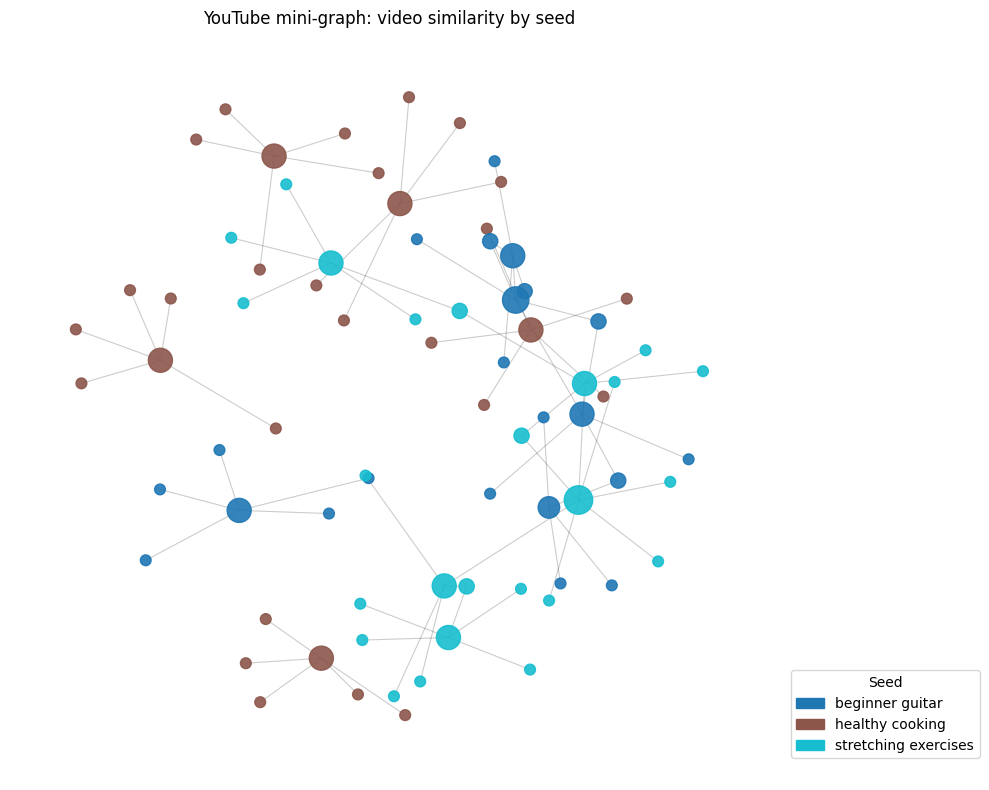

Saved figure to: figures/graph_overview.png


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# build undirected graph from edges
G = nx.from_pandas_edgelist(
    df_edges,
    source="source_video_id",
    target="video_id",
    edge_attr=["similarity"],
    create_using=nx.Graph()
)

# attach seed attribute to nodes
for n in G.nodes():
    G.nodes[n]["seed"] = seed_per_video.get(n, "unknown")

# node size by degree
deg = dict(G.degree())
node_sizes = [max(50, deg[n]*60) for n in G.nodes()]

# color nodes by seed
seeds = sorted({G.nodes[n]["seed"] for n in G.nodes()})
seed_to_int = {s:i for i,s in enumerate(seeds)}
node_colors = [seed_to_int[G.nodes[n]["seed"]] for n in G.nodes()]

# layout
pos = nx.spring_layout(G, seed=42, k=0.35)

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.8)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap=plt.cm.tab10,
    alpha=0.9
)

plt.axis("off")
plt.title("YouTube mini-graph: video similarity by seed", fontsize=12)

# legend
patches = [mpatches.Patch(color=plt.cm.tab10(seed_to_int[s]/max(1,len(seeds)-1)), label=s) for s in seeds]
plt.legend(handles=patches, title="Seed", loc="lower left", bbox_to_anchor=(1.02, 0.02))

# save figure
os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/graph_overview.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved figure to: figures/graph_overview.png")


In [27]:
# Night 7 — build and save videos_text.csv (title+description -> text)
import os
import pandas as pd

# If df_videos is not in memory, load the clean file
if "df_videos" not in globals():
    CLEAN_PATH = "data/clean/videos_clean.csv"
    assert os.path.exists(CLEAN_PATH), f"Missing file: {CLEAN_PATH}. Run the cleaning step first."
    df_videos = pd.read_csv(CLEAN_PATH)

# Build the 'text' column (safe join of title + description)
needed = {"title", "description"}
missing = needed.difference(df_videos.columns)
assert not missing, f"df_videos is missing columns required to build text: {missing}"

df_videos["text"] = (
    df_videos[["title", "description"]]
    .fillna("")            # avoid NaNs
    .agg(" ".join, axis=1) # join with space
    .str.replace(r"\s+", " ", regex=True)  # normalize whitespace
    .str.strip()
)

# Ensure output folder and save
os.makedirs("data/processed", exist_ok=True)
OUT_PATH = "data/processed/videos_text.csv"
df_videos.to_csv(OUT_PATH, index=False)

print("Saved:", OUT_PATH)
print("Rows:", len(df_videos))
print("Columns:", df_videos.columns.tolist())
# quick peek
display(df_videos.head(3)[["seed_query","video_id","title","description","text"]])


Saved: data/processed/videos_text.csv
Rows: 436
Columns: ['seed_query', 'video_id', 'title', 'description', 'channel_title', 'text']


,seed_query,video_id,title,description,text
0,healthy cooking,NarYaExBW-k,Easy &amp; Healthy Ground Beef Rice Bowls,NaN,Easy &amp; Healthy Ground Beef Rice Bowls
1,healthy cooking,izWRBNSVlc0,HEALTHY FOOD IS NOT BORING! Let me show you how,NaN,HEALTHY FOOD IS NOT BORING! Let me show you how
2,healthy cooking,6FZwdr9elLA,How to Cook Broccoli Correctly #shorts,How to Cook Broccoli Correctly #shorts #brocco...,How to Cook Broccoli Correctly #shorts How to ...


In [30]:
# TF-IDF + similarity and save artifacts
import os, json, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

os.makedirs("data/processed", exist_ok=True)

# Assumes df_videos is already loaded and has a 'text' column
assert "text" in df_videos.columns, "Missing 'text' column. Load videos_text.csv or rebuild Night 7."

# 1) TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_videos["text"])
print("TF-IDF shape:", tfidf_matrix.shape)

# Save TF-IDF artifacts
np.save("data/processed/tfidf_shape.npy", np.array(tfidf_matrix.shape))
with open("data/processed/tfidf_vocabulary.json", "w") as f:
    json.dump(vectorizer.vocabulary_, f, default=int)  # <- converte numpy.int64 pra int

# (Optional) store the sparse matrix as .npy (dense is small here) or skip if large datasets
S = cosine_similarity(tfidf_matrix)   # (N x N) dense; OK for ~435 videos
np.save("data/processed/similarity_matrix.npy", S)

# 2) Top-K similar pairs as an edges CSV (compact and handy)
TOPK = 5
rows = []
np.fill_diagonal(S, 0.0)
for i in range(S.shape[0]):
    idx = np.argpartition(-S[i], TOPK)[:TOPK]
    idx = idx[np.argsort(-S[i, idx])]
    for j in idx:
        rows.append({
            "src_idx": i,
            "src_video_id": df_videos.iloc[i]["video_id"],
            "dst_idx": int(j),
            "dst_video_id": df_videos.iloc[j]["video_id"],
            "similarity": float(S[i, j])
        })

df_topk = pd.DataFrame(rows)
df_topk.to_csv("data/processed/similarity_topk_edges.csv", index=False)

# 3) (Optional) save tokens if created
if "tokens" in df_videos.columns:
    df_videos.to_csv("data/processed/videos_tokens.csv", index=False)

print("Saved:")
print(" - data/processed/tfidf_shape.npy")
print(" - data/processed/tfidf_vocabulary.json")
print(" - data/processed/similarity_matrix.npy")
print(" - data/processed/similarity_topk_edges.csv")
if "tokens" in df_videos.columns:
    print(" - data/processed/videos_tokens.csv")


TF-IDF shape: (436, 1791)
Saved:
 - data/processed/tfidf_shape.npy
 - data/processed/tfidf_vocabulary.json
 - data/processed/similarity_matrix.npy
 - data/processed/similarity_topk_edges.csv


In [34]:
# NameError: name 'N_CLUSTERS' is not defined - Ponto de parada
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())

def top_terms(cluster_id, topn=12):
    # centroid weights for this cluster
    centroid = kmeans.cluster_centers_[cluster_id]
    idx = np.argsort(-centroid)[:topn]
    return feature_names[idx].tolist()

for c in range (N_CLUSTERS):
    print(f"Cluster {c}: ", top_terms(c, topn=12))


NameError: name 'N_CLUSTERS' is not defined

In [ ]:
import os
os.makedirs("data/processed", exist_ok=True)
df_videos.to_csv("data/processed/videos_with_clusters.csv", index=False)

# tiny summary CSV
cluster_summary = (
    df_videos.groupby(["cluster","seed_query"])
             .size()
             .reset_index(name="count")
)
cluster_summary.to_csv("data/processed/cluster_seed_counts.csv", index=False)

print("Saved:")
print(" - data/processed/videos_with_clusters.csv")
print(" - data/processed/cluster_seed_counts.csv")


In [ ]:
# CHECKLIST (single cell)
import os, json, numpy as np, pandas as pd

# Adjust if you us e another Drive folder name
DRIVE_BASE = "/content/drive/MyDrive/yt_mini_project"

def exists(p):
    return os.path.exists(p)

def ok(name, cond):
    print(f"[{'OK' if cond else 'MISS'}] {name}")

# 1) Local files expected
local_expected = [
    "data/clean/videos_clean.csv",
    "data/clean/edges_clean.csv",
    "data/processed/similarity_matrix.npy",
    "data/processed/similarity_topk_edges.csv",
    "data/processed/tfidf_vectorizer.joblib"  # if you saved via Option B
]
print("== Local files ==")
for p in local_expected:
    ok(p, exists(p))

# 2) Drive files expected
drive_expected = [
    f"{DRIVE_BASE}/data/clean/videos_clean.csv",
    f"{DRIVE_BASE}/data/clean/edges_clean.csv",
    f"{DRIVE_BASE}/data/processed/similarity_matrix.npy",
    f"{DRIVE_BASE}/data/processed/similarity_topk_edges.csv",
    f"{DRIVE_BASE}/data/processed/tfidf_vectorizer.joblib",
    f"{DRIVE_BASE}/figures/graph_overview.png",
    f"{DRIVE_BASE}/figures/graph_lcc.png",
]
print("\n== Drive files ==")
for p in drive_expected:
    ok(p, exists(p))

# 3) Load dataframes and check columns
print("\n== DataFrame sanity ==")
try:
    df_videos = pd.read_csv("data/clean/videos_clean.csv")
    ok("Loaded data/clean/videos_clean.csv", True)
    ok("Column 'text' present", "text" in df_videos.columns)
    ok("Column 'seed_query' present", "seed_query" in df_videos.columns)
except Exception as e:
    ok("Loaded data/clean/videos_clean.csv", False)
    print("Error:", e)
    df_videos = None

try:
    df_edges = pd.read_csv("data/clean/edges_clean.csv")
    ok("Loaded data/clean/edges_clean.csv", True)
    ok("Edges columns present", {"source_video_id","video_id"}.issubset(df_edges.columns))
except Exception as e:
    ok("Loaded data/clean/edges_clean.csv", False)
    print("Error:", e)
    df_edges = None

# 4) Basic shapes and integrity
if df_videos is not None:
    print("\nVideos rows:", len(df_videos))
    if "cluster" in df_videos.columns:
        print("Cluster labels found. Counts:")
        print(df_videos["cluster"].value_counts().sort_index())
    else:
        print("Column 'cluster' not found yet (run Night 11 KMeans).")

if df_edges is not None:
    print("\nEdges rows:", len(df_edges))
    if df_videos is not None and {"source_video_id","video_id"}.issubset(df_edges.columns):
        vids = set(df_videos["video_id"])
        bad = df_edges[~df_edges["source_video_id"].isin(vids) | ~df_edges["video_id"].isin(vids)]
        print("Edges referencing missing nodes:", len(bad))

# 5) Similarity artifacts
print("\n== Similarity artifacts ==")
try:
    S = np.load("data/processed/similarity_matrix.npy")
    print("similarity_matrix.npy shape:", S.shape)
    ok("Square matrix", S.shape[0] == S.shape[1])
except Exception as e:
    print("Could not load similarity_matrix.npy:", e)

if os.path.exists("data/processed/similarity_topk_edges.csv"):
    try:
        df_topk = pd.read_csv("data/processed/similarity_topk_edges.csv")
        print("similarity_topk_edges.csv rows:", len(df_topk))
        ok("TopK required columns", {"src_video_id","dst_video_id","similarity"}.issubset(df_topk.columns))
    except Exception as e:
        print("Could not read similarity_topk_edges.csv:", e)

# 6) Figures presence
print("\n== Figures ==")
ok("figures/graph_overview.png", os.path.exists("figures/graph_overview.png"))
ok("figures/graph_lcc.png", os.path.exists("figures/graph_lcc.png"))


In [24]:
# Build + save similarity_topk_edges.csv and back up to Drive

import numpy as np, pandas as pd, os

# 1) Load the processed videos WITH 'text' (Night 7)
df_videos_order = pd.read_csv("/content/drive/MyDrive/videos_text.csv")  # has column 'text'
S = np.load("data/processed/similarity_matrix.npy")

assert len(df_videos_order) == S.shape[0], "Row count mismatch. Recompute TF-IDF/Similarity with this df."

# 2) Create Top-K edges for ALL videos
TOPK = 5
rows = []
np.fill_diagonal(S, 0.0)
for i in range(S.shape[0]):
    idx = np.argpartition(-S[i], TOPK)[:TOPK]
    idx = idx[np.argsort(-S[i, idx])]
    for j in idx:
        rows.append({
            "src_idx": i,
            "src_video_id": df_videos_order.iloc[i]["video_id"],
            "dst_idx": int(j),
            "dst_video_id": df_videos_order.iloc[j]["video_id"],
            "similarity": float(S[i, j]),
        })

df_topk = pd.DataFrame(rows)

# 3) Save locally
os.makedirs("data/processed", exist_ok=True)
out_local = "data/processed/similarity_topk_edges.csv"
df_topk.to_csv(out_local, index=False)
print("Saved:", out_local, "rows:", len(df_topk))

# 4) Backup to Drive
BASE = "/content/drive/MyDrive/yt_mini_project"
os.makedirs(f"{BASE}/data/processed", exist_ok=True)
out_drive = f"{BASE}/data/processed/similarity_topk_edges.csv"
df_topk.to_csv(out_drive, index=False)
print("Backed up to:", out_drive)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/videos_text.csv'

In [ ]:
# NIGHT 10–11 CHECKLIST (single cell)
import os, json, numpy as np, pandas as pd

# Adjust if you us e another Drive folder name
DRIVE_BASE = "/content/drive/MyDrive/yt_mini_project"

def exists(p):
    return os.path.exists(p)

def ok(name, cond):
    print(f"[{'OK' if cond else 'MISS'}] {name}")

# 1) Local files expected
local_expected = [
    "data/clean/videos_clean.csv",
    "data/clean/edges_clean.csv",
    "data/processed/similarity_matrix.npy",
    "data/processed/similarity_topk_edges.csv",
    "data/processed/tfidf_vectorizer.joblib"  # if you saved via Option B
]
print("== Local files ==")
for p in local_expected:
    ok(p, exists(p))

# 2) Drive files expected
drive_expected = [
    f"{DRIVE_BASE}/data/clean/videos_clean.csv",
    f"{DRIVE_BASE}/data/clean/edges_clean.csv",
    f"{DRIVE_BASE}/data/processed/similarity_matrix.npy",
    f"{DRIVE_BASE}/data/processed/similarity_topk_edges.csv",
    f"{DRIVE_BASE}/data/processed/tfidf_vectorizer.joblib",
    f"{DRIVE_BASE}/figures/graph_overview.png",
    f"{DRIVE_BASE}/figures/graph_lcc.png",
]
print("\n== Drive files ==")
for p in drive_expected:
    ok(p, exists(p))

# 3) Load dataframes and check columns
print("\n== DataFrame sanity ==")
try:
    df_videos = pd.read_csv("data/clean/videos_clean.csv")
    ok("Loaded data/clean/videos_clean.csv", True)
    ok("Column 'text' present", "text" in df_videos.columns)
    ok("Column 'seed_query' present", "seed_query" in df_videos.columns)
except Exception as e:
    ok("Loaded data/clean/videos_clean.csv", False)
    print("Error:", e)
    df_videos = None

try:
    df_edges = pd.read_csv("data/clean/edges_clean.csv")
    ok("Loaded data/clean/edges_clean.csv", True)
    ok("Edges columns present", {"source_video_id","video_id"}.issubset(df_edges.columns))
except Exception as e:
    ok("Loaded data/clean/edges_clean.csv", False)
    print("Error:", e)
    df_edges = None

# 4) Basic shapes and integrity
if df_videos is not None:
    print("\nVideos rows:", len(df_videos))
    if "cluster" in df_videos.columns:
        print("Cluster labels found. Counts:")
        print(df_videos["cluster"].value_counts().sort_index())
    else:
        print("Column 'cluster' not found yet (run Night 11 KMeans).")

if df_edges is not None:
    print("\nEdges rows:", len(df_edges))
    if df_videos is not None and {"source_video_id","video_id"}.issubset(df_edges.columns):
        vids = set(df_videos["video_id"])
        bad = df_edges[~df_edges["source_video_id"].isin(vids) | ~df_edges["video_id"].isin(vids)]
        print("Edges referencing missing nodes:", len(bad))

# 5) Similarity artifacts
print("\n== Similarity artifacts ==")
try:
    S = np.load("data/processed/similarity_matrix.npy")
    print("similarity_matrix.npy shape:", S.shape)
    ok("Square matrix", S.shape[0] == S.shape[1])
except Exception as e:
    print("Could not load similarity_matrix.npy:", e)

if os.path.exists("data/processed/similarity_topk_edges.csv"):
    try:
        df_topk = pd.read_csv("data/processed/similarity_topk_edges.csv")
        print("similarity_topk_edges.csv rows:", len(df_topk))
        ok("TopK required columns", {"src_video_id","dst_video_id","similarity"}.issubset(df_topk.columns))
    except Exception as e:
        print("Could not read similarity_topk_edges.csv:", e)

# 6) Figures presence
print("\n== Figures ==")
ok("figures/graph_overview.png", os.path.exists("figures/graph_overview.png"))
ok("figures/graph_lcc.png", os.path.exists("figures/graph_lcc.png"))


In [ ]:
import pandas as pd

df_videos_text = pd.read_csv("/content/drive/MyDrive/videos_text.csv")
print("Columns:", df_videos_text.columns)
print(df_videos_text.head(3))


In [ ]:
# NIGHT 10–11 CHECKLIST (revised to use videos_text.csv)
import os, json, numpy as np, pandas as pd

DRIVE_BASE = "/content/drive/MyDrive/yt_mini_project"

def exists(p):
    return os.path.exists(p)

def ok(name, cond):
    print(f"[{'OK' if cond else 'MISS'}] {name}")

# 1) Local files expected
local_expected = [
    "data/clean/edges_clean.csv",
    "data/processed/similarity_matrix.npy",
    "data/processed/similarity_topk_edges.csv",
    "data/processed/tfidf_vectorizer.joblib"  # if you saved via Option B
]
print("== Local files ==")
for p in local_expected:
    ok(p, exists(p))

# 2) Drive files expected
drive_expected = [
    f"{DRIVE_BASE}/data/clean/edges_clean.csv",
    f"{DRIVE_BASE}/data/processed/similarity_matrix.npy",
    f"{DRIVE_BASE}/data/processed/similarity_topk_edges.csv",
    f"{DRIVE_BASE}/data/processed/tfidf_vectorizer.joblib",
    f"{DRIVE_BASE}/figures/graph_overview.png",
    f"{DRIVE_BASE}/figures/graph_lcc.png",
    f"{DRIVE_BASE}/videos_text.csv"
]
print("\n== Drive files ==")
for p in drive_expected:
    ok(p, exists(p))

# 3) Load videos_text (with text column)
print("\n== DataFrame sanity (videos_text.csv) ==")
try:
    df_videos = pd.read_csv(f"{DRIVE_BASE}/videos_text.csv")
    ok("Loaded videos_text.csv", True)
    ok("Column 'text' present", "text" in df_videos.columns)
    ok("Column 'seed_query' present", "seed_query" in df_videos.columns)
except Exception as e:
    ok("Loaded videos_text.csv", False)
    print("Error:", e)
    df_videos = None

# 4) Load edges_clean
print("\n== Edges check ==")
try:
    df_edges = pd.read_csv("data/clean/edges_clean.csv")
    ok("Loaded data/clean/edges_clean.csv", True)
    ok("Edges columns present", {"source_video_id","video_id"}.issubset(df_edges.columns))
except Exception as e:
    ok("Loaded data/clean/edges_clean.csv", False)
    print("Error:", e)
    df_edges = None

# 5) Shapes + clusters
if df_videos is not None:
    print("\nVideos rows:", len(df_videos))
    if "cluster" in df_videos.columns:
        print("Cluster labels found. Counts:")
        print(df_videos["cluster"].value_counts().sort_index())
    else:
        print("Column 'cluster' not found yet (run Night 11 KMeans).")

if df_edges is not None:
    print("\nEdges rows:", len(df_edges))
    if df_videos is not None and {"source_video_id","video_id"}.issubset(df_edges.columns):
        vids = set(df_videos["video_id"])
        bad = df_edges[~df_edges["source_video_id"].isin(vids) | ~df_edges["video_id"].isin(vids)]
        print("Edges referencing missing nodes:", len(bad))

# 6) Similarity artifacts
print("\n== Similarity artifacts ==")
try:
    S = np.load("data/processed/similarity_matrix.npy")
    print("similarity_matrix.npy shape:", S.shape)
    ok("Square matrix", S.shape[0] == S.shape[1])
except Exception as e:
    print("Could not load similarity_matrix.npy:", e)

if os.path.exists("data/processed/similarity_topk_edges.csv"):
    try:
        df_topk = pd.read_csv("data/processed/similarity_topk_edges.csv")
        print("similarity_topk_edges.csv rows:", len(df_topk))
        ok("TopK required columns", {"src_video_id","dst_video_id","similarity"}.issubset(df_topk.columns))
    except Exception as e:
        print("Could not read similarity_topk_edges.csv:", e)

# 7) Figures
print("\n== Figures ==")
ok("figures/graph_overview.png", os.path.exists("figures/graph_overview.png"))
ok("figures/graph_lcc.png", os.path.exists("figures/graph_lcc.png"))


In [ ]:
# NIGHT 10–11 CHECKLIST (revised to use videos_text.csv)
import os, json, numpy as np, pandas as pd

DRIVE_BASE = "/content/drive/MyDrive/yt_mini_project"

def exists(p):
    return os.path.exists(p)

def ok(name, cond):
    print(f"[{'OK' if cond else 'MISS'}] {name}")

# 1) Local files expected
local_expected = [
    "data/clean/edges_clean.csv",
    "data/processed/similarity_matrix.npy",
    "data/processed/similarity_topk_edges.csv",
    "data/processed/tfidf_vectorizer.joblib"  # if you saved via Option B
]
print("== Local files ==")
for p in local_expected:
    ok(p, exists(p))

# 2) Drive files expected
drive_expected = [
    f"{DRIVE_BASE}/data/clean/edges_clean.csv",
    f"{DRIVE_BASE}/data/processed/similarity_matrix.npy",
    f"{DRIVE_BASE}/data/processed/similarity_topk_edges.csv",
    f"{DRIVE_BASE}/data/processed/tfidf_vectorizer.joblib",
    f"{DRIVE_BASE}/figures/graph_overview.png",
    f"{DRIVE_BASE}/figures/graph_lcc.png",
    f"{DRIVE_BASE}/videos_text.csv"
]
print("\n== Drive files ==")
for p in drive_expected:
    ok(p, exists(p))

# 3) Load videos_text (with text column)
print("\n== DataFrame sanity (videos_text.csv) ==")
try:
    df_videos = pd.read_csv(f"{DRIVE_BASE}/videos_text.csv")
    ok("Loaded videos_text.csv", True)
    ok("Column 'text' present", "text" in df_videos.columns)
    ok("Column 'seed_query' present", "seed_query" in df_videos.columns)
except Exception as e:
    ok("Loaded videos_text.csv", False)
    print("Error:", e)
    df_videos = None

# 4) Load edges_clean
print("\n== Edges check ==")
try:
    df_edges = pd.read_csv("data/clean/edges_clean.csv")
    ok("Loaded data/clean/edges_clean.csv", True)
    ok("Edges columns present", {"source_video_id","video_id"}.issubset(df_edges.columns))
except Exception as e:
    ok("Loaded data/clean/edges_clean.csv", False)
    print("Error:", e)
    df_edges = None

# 5) Shapes + clusters
if df_videos is not None:
    print("\nVideos rows:", len(df_videos))
    if "cluster" in df_videos.columns:
        print("Cluster labels found. Counts:")
        print(df_videos["cluster"].value_counts().sort_index())
    else:
        print("Column 'cluster' not found yet (run Night 11 KMeans).")

if df_edges is not None:
    print("\nEdges rows:", len(df_edges))
    if df_videos is not None and {"source_video_id","video_id"}.issubset(df_edges.columns):
        vids = set(df_videos["video_id"])
        bad = df_edges[~df_edges["source_video_id"].isin(vids) | ~df_edges["video_id"].isin(vids)]
        print("Edges referencing missing nodes:", len(bad))

# 6) Similarity artifacts
print("\n== Similarity artifacts ==")
try:
    S = np.load("data/processed/similarity_matrix.npy")
    print("similarity_matrix.npy shape:", S.shape)
    ok("Square matrix", S.shape[0] == S.shape[1])
except Exception as e:
    print("Could not load similarity_matrix.npy:", e)

if os.path.exists("data/processed/similarity_topk_edges.csv"):
    try:
        df_topk = pd.read_csv("data/processed/similarity_topk_edges.csv")
        print("similarity_topk_edges.csv rows:", len(df_topk))
        ok("TopK required columns", {"src_video_id","dst_video_id","similarity"}.issubset(df_topk.columns))
    except Exception as e:
        print("Could not read similarity_topk_edges.csv:", e)

# 7) Figures
print("\n== Figures ==")
ok("figures/graph_overview.png", os.path.exists("figures/graph_overview.png"))
ok("figures/graph_lcc.png", os.path.exists("figures/graph_lcc.png"))

In [35]:
# KMeans topics + entropy by seed
import os, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 1) Load processed videos with 'text'
DF_PATH = "/content/drive/MyDrive/videos_text.csv"   # ajuste se necessário
df_videos = pd.read_csv(DF_PATH)
assert "text" in df_videos.columns and "seed_query" in df_videos.columns

# 2) TF-IDF (reuse if already in memory)
try:
    tfidf_matrix
    _ = tfidf_matrix.shape
except NameError:
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(df_videos["text"])

print("TF-IDF:", tfidf_matrix.shape)

# 3) KMeans clustering
N_CLUSTERS = 3  # você pode testar 3–6 depois
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=42)
labels = kmeans.fit_predict(tfidf_matrix)

df_videos["cluster"] = labels
print("Cluster counts:\n", df_videos["cluster"].value_counts().sort_index(), "\n")

# 4) Entropy by seed (topic distribution per seed)
def entropy(counts):
    p = counts / counts.sum()
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

# counts table: rows=seed, cols=cluster
seed_cluster_counts = (
    df_videos.groupby(["seed_query","cluster"])
             .size()
             .unstack(fill_value=0)
             .sort_index()
)

entropy_by_seed = seed_cluster_counts.apply(entropy, axis=1).rename("entropy").to_frame()
entropy_by_seed["n_videos"] = seed_cluster_counts.sum(axis=1)

print("Entropy by seed:\n", entropy_by_seed, "\n")

# 5) Save outputs
os.makedirs("data/processed", exist_ok=True)
df_videos.to_csv("data/processed/videos_with_clusters.csv", index=False)
seed_cluster_counts.to_csv("data/processed/seed_cluster_counts.csv")
entropy_by_seed.to_csv("data/processed/seed_cluster_entropy.csv")

print("Saved:")
print(" - data/processed/videos_with_clusters.csv")
print(" - data/processed/seed_cluster_counts.csv")
print(" - data/processed/seed_cluster_entropy.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/videos_text.csv'

In [ ]:
# Show 10 examples per cluster (title + channel) and save samples to CSV
import pandas as pd
import os

assert "cluster" in df_videos.columns, "Run Night 12 first to create 'cluster' labels."

examples = []
for c in sorted(df_videos["cluster"].unique()):
    sub = df_videos[df_videos["cluster"] == c].copy()
    print(f"\n=== Cluster {c} — {len(sub)} videos ===")
    # show up to 10 examples in the output
    display(sub[["title", "channel_title"]].head(10))
    # collect 20 random examples for a CSV (adjust n if needed)
    examples.append(sub.sample(min(20, len(sub)), random_state=42))

# Save a samples file for later review
os.makedirs("data/processed", exist_ok=True)
df_examples = pd.concat(examples, ignore_index=True)
df_examples.to_csv("data/processed/cluster_examples.csv", index=False)
print("\nSaved: data/processed/cluster_examples.csv")


In [ ]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 0) Garantias e carregamentos
# df_videos precisa ter 'video_id', 'seed_query', 'cluster'
assert {"video_id","seed_query","cluster"}.issubset(df_videos.columns)

# Similaridade: usa a que já existe; se não, calcula agora a partir do TF-IDF
try:
    S  # similarity matrix already in memory
    _ = S.shape
except NameError:
    try:
        # tenta carregar do disco
        S = np.load("data/processed/similarity_matrix.npy")
    except Exception:
        from sklearn.metrics.pairwise import cosine_similarity
        S = cosine_similarity(tfidf_matrix)
# zera diagonal para não selecionar o próprio vídeo
np.fill_diagonal(S, 0.0)

# Índices auxiliares
vids = df_videos["video_id"].tolist()
id2idx = {v:i for i,v in enumerate(vids)}

# 1) Parâmetros da caminhada
SEED_START_PER_SEED = 5   # quantos vídeos iniciais por seed (passo 0)
TOPK_PER_NODE       = 5   # quantos vizinhos cada nó traz por passo
N_STEPS             = 3   # nº de passos (0=seeds, 1, 2, 3...)

rng = np.random.default_rng(42)

# 2) Selecionar seeds (passo 0) — usa amostra estável por seed
seed_names = sorted(df_videos["seed_query"].unique().tolist())
seed_start_indices = {}
for s in seed_names:
    idxs = df_videos.index[df_videos["seed_query"]==s].tolist()
    pick = rng.choice(idxs, size=min(SEED_START_PER_SEED, len(idxs)), replace=False)
    seed_start_indices[s] = set(int(i) for i in pick)

# 3) Caminhada por passos (expansão cumulativa por similaridade)
walk_records = []  # (seed, step, video_id)
frontier = {s: set(seed_start_indices[s]) for s in seed_names}
visited  = {s: set(seed_start_indices[s]) for s in seed_names}

# passo 0 (seeds)
for s in seed_names:
    for i in sorted(visited[s]):
        walk_records.append((s, 0, vids[i]))

# passos 1..N
for step in range(1, N_STEPS+1):
    new_frontier = {s: set() for s in seed_names}
    for s in seed_names:
        for i in frontier[s]:
            # pega TOPK vizinhos mais similares do nó i
            row = S[i]
            if TOPK_PER_NODE >= len(row):
                cand_idx = np.argsort(-row)[:TOPK_PER_NODE]
            else:
                # escolha eficiente: partição + ordenação local
                cand_idx = np.argpartition(-row, TOPK_PER_NODE)[:TOPK_PER_NODE]
                cand_idx = cand_idx[np.argsort(-row[cand_idx])]
            # adiciona não-visitados
            for j in cand_idx:
                if j not in visited[s]:
                    visited[s].add(int(j))
                    new_frontier[s].add(int(j))
                    walk_records.append((s, step, vids[j]))
    frontier = new_frontier

# DataFrame com (seed, step, video_id)
df_walk = pd.DataFrame(walk_records, columns=["seed_query","step","video_id"])

# 4) Entropia cumulativa por seed e passo (usando 'cluster' de df_videos)
# junta cluster
df_walk = df_walk.merge(df_videos[["video_id","cluster"]], on="video_id", how="left")

def entropy_from_counts(counts):
    p = counts / counts.sum()
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

# calcula cumulativo: para cada seed, do passo 0..t
rows = []
for s in seed_names:
    df_s = df_walk[df_walk["seed_query"]==s]
    for t in range(0, N_STEPS+1):
        df_cum = df_s[df_s["step"]<=t]
        counts = df_cum["cluster"].value_counts().sort_index()
        ent = entropy_from_counts(counts)
        rows.append({"seed_query": s, "step": t, "entropy": ent, "n_videos": int(len(df_cum))})

df_ent_step = pd.DataFrame(rows)

# 5) Plot: Entropy vs Step (linha por seed)
os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(7,4))
for s in seed_names:
    sub = df_ent_step[df_ent_step["seed_query"]==s].sort_values("step")
    plt.plot(sub["step"], sub["entropy"], marker="o", label=s)
plt.xlabel("Step (cumulative)")
plt.ylabel("Entropy of clusters")
plt.title("Entropy vs Step (cumulative by seed)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/entropy_vs_step.png", dpi=150, bbox_inches="tight")
plt.show()

# 6) Salvar artefatos
os.makedirs("data/processed", exist_ok=True)
df_walk.to_csv("data/processed/walk_steps.csv", index=False)
df_ent_step.to_csv("data/processed/entropy_vs_step.csv", index=False)
print("Saved:")
print(" - figures/entropy_vs_step.png")
print(" - data/processed/walk_steps.csv")
print(" - data/processed/entropy_vs_step.csv")


In [ ]:
# Night 14.2 — Jaccard heatmap between seeds (real data)
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 1) Load videos with seed + video_id (prefer processed file with clusters)
CANDIDATES = [
    "data/processed/videos_with_clusters.csv",
    "/content/drive/MyDrive/yt_mini_project/data/processed/videos_with_clusters.csv",
    "/content/drive/MyDrive/yt_mini_project/videos_text.csv",
]
found = None
for p in CANDIDATES:
    if os.path.exists(p):
        found = p
        break
assert found, "Could not find a videos file. Make sure one of the candidates exists."

df_videos = pd.read_csv(found)
assert {"seed_query","video_id"}.issubset(df_videos.columns)

# 2) Build sets of video_ids per seed
seeds = sorted(df_videos["seed_query"].unique().tolist())
sets_by_seed = {s: set(df_videos.loc[df_videos["seed_query"]==s, "video_id"]) for s in seeds}

# 3) Compute Jaccard matrix
J = np.zeros((len(seeds), len(seeds)), dtype=float)
for i,a in enumerate(seeds):
    for j,b in enumerate(seeds):
        inter = len(sets_by_seed[a] & sets_by_seed[b])
        union = len(sets_by_seed[a] | sets_by_seed[b])
        J[i,j] = inter/union if union else 0.0

df_j = pd.DataFrame(J, index=seeds, columns=seeds)

# 4) Plot heatmap (with value annotations)
os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(5.5, 4.5))
im = plt.imshow(J, vmin=0, vmax=1, aspect="auto")
plt.xticks(range(len(seeds)), seeds, rotation=45, ha="right")
plt.yticks(range(len(seeds)), seeds)
plt.colorbar(im, label="Jaccard")

for i in range(len(seeds)):
    for j in range(len(seeds)):
        plt.text(j, i, f"{J[i,j]:.2f}", ha="center", va="center", fontsize=9)

plt.title("Jaccard similarity between seeds (videos)")
plt.tight_layout()
plt.savefig("figures/jaccard_seeds_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

# 5) Save CSV
os.makedirs("data/processed", exist_ok=True)
df_j.to_csv("data/processed/jaccard_seeds.csv")
print("Saved: figures/jaccard_seeds_heatmap.png, data/processed/jaccard_seeds.csv")


In [ ]:
# Top terms per cluster from KMeans centroids
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())

def top_terms(cluster_id, topn=12):
    centroid = kmeans.cluster_centers_[cluster_id]
    idx = np.argsort(-centroid)[:topn]
    return feature_names[idx].tolist()

for c in sorted(df_videos["cluster"].unique()):
    print(f"Cluster {c} top terms:", top_terms(c, topn=12))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# carregar a matriz Jaccard já salva
df_j = pd.read_csv("data/processed/jaccard_seeds.csv", index_col=0)

# diversidade = 1 - média da similaridade com outras seeds
diversity = {}
for seed in df_j.index:
    others = [v for s,v in df_j.loc[seed].items() if s != seed]
    diversity[seed] = 1 - np.mean(others)

df_div = pd.DataFrame.from_dict(diversity, orient="index", columns=["diversity"]).sort_values("diversity", ascending=False)

# plot
plt.figure(figsize=(6,4))
df_div["diversity"].plot(kind="bar", color="skyblue")
plt.ylabel("Average Diversity (1 - mean Jaccard)")
plt.title("Average Diversity per Seed")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/diversity_per_seed.png", dpi=150, bbox_inches="tight")
plt.show()

# save CSV
df_div.to_csv("data/processed/diversity_per_seed.csv")
print("Saved: figures/diversity_per_seed.png, data/processed/diversity_per_seed.csv")


In [ ]:
import pandas as pd

df_diversity = pd.read_csv("data/processed/diversity_per_seed.csv")
print(df_diversity)


In [ ]:
# Recompute diversity per seed using normalized Shannon entropy
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Load videos with cluster labels
CANDIDATES = [
    "data/processed/videos_with_clusters.csv",
    "/content/drive/MyDrive/yt_mini_project/data/processed/videos_with_clusters.csv",
]
found = next((p for p in CANDIDATES if os.path.exists(p)), None)
assert found, "videos_with_clusters.csv not found. Run Night 12 first."
df = pd.read_csv(found)

assert {"seed_query","cluster"}.issubset(df.columns)

# How many clusters exist?
K = int(df["cluster"].nunique())
assert K >= 2, f"Need at least 2 clusters; found K={K}"

def entropy(counts):
    p = counts / counts.sum()
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

# counts table: rows=seed, cols=cluster
counts = df.groupby(["seed_query","cluster"]).size().unstack(fill_value=0).sort_index()

# Shannon entropy (0..log2 K) and normalized diversity = entropy/log2(K)
ent = counts.apply(entropy, axis=1)
diversity_norm = ent / np.log2(K)

df_div = pd.DataFrame({
    "seed_query": counts.index,
    "entropy": ent.values,
    "diversity_norm": diversity_norm.values,
    "n_videos": counts.sum(axis=1).values
}).sort_values("diversity_norm", ascending=False)

# Save table
os.makedirs("data/processed", exist_ok=True)
out_csv = "data/processed/diversity_per_seed.csv"
df_div.to_csv(out_csv, index=False)

print("Recomputed diversity:")
print(df_div, "\n")
print("Saved:", out_csv)

# Plot bars
os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(7,4))
plt.bar(df_div["seed_query"], df_div["diversity_norm"])
plt.ylabel("Normalized diversity (entropy / log2 K)")
plt.title("Diversity by seed")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
out_fig = "figures/diversity_per_seed.png"
plt.savefig(out_fig, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", out_fig)


In [ ]:
import os, pandas as pd, numpy as np
from itertools import combinations

# 1) carregar dados reais
CANDIDATES = [
    "data/processed/videos_with_clusters.csv",
    "/content/drive/MyDrive/yt_mini_project/data/processed/videos_with_clusters.csv",
    "/content/drive/MyDrive/yt_mini_project/videos_text.csv",
]
found = next((p for p in CANDIDATES if os.path.exists(p)), None)
assert found, "Nenhum arquivo de vídeos encontrado."
df = pd.read_csv(found)
assert {"seed_query","video_id","title"}.issubset(df.columns)

print("Loaded:", found, "| rows:", len(df))
print("Seeds:", sorted(df['seed_query'].unique().tolist()))

# 2) mapa seed -> conjuntos
sets_vid = {s: set(df.loc[df.seed_query==s, "video_id"]) for s in df.seed_query.unique()}
sets_ch  = {s: set(df.loc[df.seed_query==s, "channel_title"].dropna()) for s in df.seed_query.unique()}

# 3) interseção de video_ids entre seeds
print("\n== Overlap de VIDEO_IDs entre seeds ==")
for a,b in combinations(sorted(sets_vid.keys()), 2):
    inter = sets_vid[a] & sets_vid[b]
    print(f"{a} ∩ {b}: {len(inter)}")
    if len(inter) > 0:
        ex = list(inter)[:5]
        print("  exemplos:")
        disp = df[df.video_id.isin(ex)][["video_id","title","seed_query"]].drop_duplicates()
        display(disp)

# 4) checar se algum video_id aparece com MAIS de uma seed
dups = (df.duplicated("video_id", keep=False))
multi_seed = (df[dups].groupby("video_id")["seed_query"].nunique()>1)
multi_seed_ids = multi_seed[multi_seed].index.tolist()
print(f"\nVideo_ids presentes em MULTIPLAS seeds: {len(multi_seed_ids)}")
if multi_seed_ids:
    display(df[df.video_id.isin(multi_seed_ids)][["video_id","title","seed_query"]].drop_duplicates().head(20))

# 5) (sanity) interseção por CANAL
print("\n== Overlap de CANAIS entre seeds ==")
for a,b in combinations(sorted(sets_ch.keys()), 2):
    inter = sets_ch[a] & sets_ch[b]
    print(f"{a} ∩ {b}: {len(inter)}")
    if len(inter) > 0:
        print("  exemplos:", list(sorted(inter))[:10])

# 6) Jaccard por video_id (confirmando seu heatmap)
seeds = sorted(sets_vid.keys())
J = np.zeros((len(seeds), len(seeds)))
for i,a in enumerate(seeds):
    for j,b in enumerate(seeds):
        inter = len(sets_vid[a] & sets_vid[b])
        union = len(sets_vid[a] | sets_vid[b])
        J[i,j] = inter/union if union else 0.0
print("\nMatriz Jaccard (videos):")
print(pd.DataFrame(J, index=seeds, columns=seeds).round(3))


## Data collection
Queries YouTube Data API v3 using **seed queries** (e.g., *healthy cooking*, *beginner guitar*, *stretching exercises*). Collects a pool per seed with `search.list`, storing `video_id`, `title`, `description`, `channel_title`.
Note: we no longer rely on `relatedToVideoId` (YouTube has limited that path); instead we approximate relatedness later via content similarity.

In [ ]:
def search_paged(query, max_items=150):
    """
    Fetch up to `max_items` videos for a query using pageToken pagination.
    Returns a DataFrame with: seed_query, video_id, title, description, channel_title.
    """
    rows, token = [], None
    while len(rows) < max_items:
        params = {
            "part": "snippet", "q": query, "type": "video",
            "maxResults": 50, "key": API_KEY
        }
        if token:
            params["pageToken"] = token
        r = requests.get(SEARCH_URL, params=params)
        r.raise_for_status()
        data = r.json()

        for it in data.get("items", []):
            rows.append({
                "seed_query": query,
                "video_id": it["id"]["videoId"],
                "title": it["snippet"].get("title",""),
                "description": it["snippet"].get("description",""),
                "channel_title": it["snippet"].get("channelTitle",""),
            })
            if len(rows) >= max_items:
                break

        token = data.get("nextPageToken")
        if not token:
            break

    return pd.DataFrame(rows)

def build_edges_tfidf(df_pool, seeds_df, k=5):
    """
    For each seed (title+description), returns top-k most similar videos from the pool.
    Output columns: seed_query, source_video_id, video_id, title, channel_title, similarity.
    """
    text = (df_pool["title"].fillna("") + " " + df_pool["description"].fillna("")).values
    tfidf = TfidfVectorizer(lowercase=True, stop_words="english", max_features=20000)
    X = tfidf.fit_transform(text)
    idx_by_id = {vid: i for i, vid in enumerate(df_pool["video_id"].tolist())}

    edges = []
    for _, seed in seeds_df.iterrows():
        seed_text = (str(seed.get("title","")) + " " + str(seed.get("description",""))).strip()
        x_seed = tfidf.transform([seed_text])
        sims = cosine_similarity(x_seed, X)[0]
        # exclude the seed itself if it’s in the pool
        if seed["video_id"] in idx_by_id:
            sims[idx_by_id[seed["video_id"]]] = -1.0
        top_idx = np.argsort(-sims)[:k]
        for i in top_idx:
            row = df_pool.iloc[i]
            edges.append({
                "seed_query": seed["seed_query"],
                "source_video_id": seed["video_id"],
                "video_id": row["video_id"],
                "title": row["title"],
                "channel_title": row["channel_title"],
                "similarity": float(sims[i]),
            })
    return pd.DataFrame(edges)


## Preprocessing
Lower-case, de-HTML (`&amp;`→`and`), strip punctuation, and concatenate `title + description` into a `text` column. Remove duplicates by `video_id` and save clean tables.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Text field: title + description
pool_text = (df_pool["title"].fillna("") + " " + df_pool["description"].fillna("")).values

# Fit TF-IDF on the pool
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",      # simple English stopwords
    max_features=20000
)
X_pool = tfidf.fit_transform(pool_text)

# Map video_id -> row index
idx_by_id = {vid: i for i, vid in enumerate(df_pool["video_id"].tolist())}


In [ ]:
# Nodes: union of seeds + pool (you can enrich later with stats)
df_nodes = df_pool.drop_duplicates(subset=["video_id"]).copy()
df_nodes.to_csv("videos_pool.csv", index=False)
df_edges_step1.to_csv("edges_step1_tfidf.csv", index=False)

print("Saved: videos_pool.csv and edges_step1_tfidf.csv")


In [ ]:
SEEDS       = ["healthy cooking", "beginner guitar", "stretching exercises"]
POOL_SIZE   = 150   # videos per seed (≈3 pages)
SEED_COUNT  = 5     # seed videos per query
TOPK        = 5     # neighbors per seed video

all_nodes, all_edges = [], []

for q in SEEDS:
    df_pool = search_paged(q, max_items=POOL_SIZE)
    df_seed_local = df_pool.head(SEED_COUNT).copy()
    df_edges = build_edges_tfidf(df_pool, df_seed_local, k=TOPK)

    all_nodes.append(df_pool)
    all_edges.append(df_edges)
    print(f"[{q}] pool={len(df_pool)} edges={len(df_edges)}")

# Concatenate & dedupe
df_nodes_raw = pd.concat(all_nodes, ignore_index=True).drop_duplicates(subset=["video_id"])
df_edges_raw = pd.concat(all_edges, ignore_index=True).drop_duplicates()

# Save to data/raw/
nodes_path = "data/raw/videos_raw.csv"
edges_path = "data/raw/edges_raw.csv"
df_nodes_raw.to_csv(nodes_path, index=False)
df_edges_raw.to_csv(edges_path, index=False)

print(f"\nSaved:\n  {nodes_path} ({len(df_nodes_raw)} rows)\n  {edges_path} ({len(df_edges_raw)} rows)")


In [ ]:
def tokenize(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower())  # remove tudo que não é letra
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]  # remove stopwords e palavras curtas
    return tokens

df_videos["tokens"] = df_videos["text"].apply(tokenize)
df_videos[["text", "tokens"]].head(3)


In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# 1. Clean text (split, remove stopwords, punctuation)
def tokenize(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters + space
    tokens = text.split()
    return tokens

# 2. Tokenize all rows
all_tokens = []
for t in df_videos["text"]:
    all_tokens.extend(tokenize(t))

print("Total tokens:", len(all_tokens))

# 3. Count frequencies
counter = Counter(all_tokens)
most_common = counter.most_common(20)

# 4. Plot top 20 words
words, counts = zip(*most_common)
plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 most frequent words")
plt.show()


In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def tokenize(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

# Tokenize all rows and count
all_tokens = [tok for txt in df_videos["text"] for tok in tokenize(txt)]
counter = Counter(all_tokens)
most_common = counter.most_common(20)

# Plot again
words, counts = zip(*most_common)
plt.figure(figsize=(10,5))
plt.bar(words, counts, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 words (stopwords removed)")
plt.show()


## TF‑IDF & Similarity
Vectorize `text` with `TfidfVectorizer(min_df=2)` and compute cosine similarity. Persist the TF‑IDF model and (optionally) a similarity matrix or top‑K neighbor pairs.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
# Transform texts into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)  # limita para evitar explosão
tfidf_matrix = vectorizer.fit_transform(df_videos["text"])

print("TF-IDF shape:", tfidf_matrix.shape)  # (n_samples, n_features)


In [ ]:
# Compute cosine similarity between all videos
similarity_matrix = cosine_similarity(tfidf_matrix)

print("Similarity matrix shape:", similarity_matrix.shape)


In [ ]:
import joblib
joblib.dump(vectorizer, "data/processed/tfidf_vectorizer.joblib")


In [ ]:
S = cosine_similarity(tfidf_matrix)
np.save("data/processed/similarity_matrix.npy", S)
# ... e o bloco que gera similarity_topk_edges.csv


## Clustering
Run `KMeans` to group videos into coarse topical clusters. Append `cluster` labels to the videos table.

In [ ]:
from sklearn.cluster import KMeans

N_CLUSTERS = 3  # you can try 3–6 later
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=42)
labels = kmeans.fit_predict(tfidf_matrix)

df_videos["cluster"] = labels
print(df_videos["cluster"].value_counts().sort_index())


## Metrics
Compute simple indicators: normalized entropy of cluster distribution per seed (diversity proxy), Jaccard overlap between seeds (by `video_id`), and an *entropy vs. step* curve to approximate how diversity evolves as the user keeps consuming content.

In [ ]:
# most frequent seed per video_id
seed_per_video = (
    df_videos.groupby("video_id")["seed_query"]
    .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else "unknown")
    .to_dict()
)
list(seed_per_video.items())[:5]  # quick peek


In [ ]:
components = sorted(nx.connected_components(G), key=len, reverse=True)
G_main = G.subgraph(components[0]).copy()

pos = nx.spring_layout(G_main, seed=42, k=0.35)
deg_main = dict(G_main.degree())
node_sizes = [max(50, deg_main[n]*60) for n in G_main.nodes()]
node_colors = [seed_to_int[G_main.nodes[n]["seed"]] for n in G_main.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G_main, pos, alpha=0.25, width=0.9)
nx.draw_networkx_nodes(G_main, pos, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.tab10, alpha=0.95)
plt.axis("off")
plt.title("Largest connected component", fontsize=12)
plt.tight_layout()
plt.savefig("figures/graph_lcc.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved figure to: figures/graph_lcc.png")


In [ ]:
print(
    df_videos.groupby(["cluster","seed_query"])
             .size()
             .unstack(fill_value=0)
)


## Appendix (utilities)
Helper snippets retained for completeness.

In [ ]:
def search_videos_by_query(query, max_results=25, region_code="US", outfile=None):
    """
    Search videos by keyword, enrich with category name and view count,
    and optionally save to CSV. Returns a pandas DataFrame.
    """
    # 1) Get candidate video IDs (search.list only returns lightweight info)
    search_resp = youtube.search().list(
        part="snippet",
        q=query,
        type="video",
        maxResults=min(max_results, 50)  # API per-call limit
    ).execute()

    items = search_resp.get("items", [])
    video_ids = [it["id"]["videoId"] for it in items]

    if not video_ids:
        print("No videos found for:", query)
        return pd.DataFrame()

    # 2) Fetch full details/statistics for those IDs (videos.list)
    videos_resp = youtube.videos().list(
        part="snippet,statistics",
        id=",".join(video_ids)
    ).execute()

    cat_map = get_category_map(region_code)

    rows = []
    for v in videos_resp.get("items", []):
        vid   = v["id"]
        snip  = v["snippet"]
        stats = v.get("statistics", {})
        cat_id = snip.get("categoryId", "")
        rows.append({
            "query": query,
            "video_id": vid,
            "title": snip.get("title", ""),
            "channel_title": snip.get("channelTitle", ""),
            "category_id": cat_id,
            "category_name": cat_map.get(cat_id, ""),
            "view_count": int(stats.get("viewCount", 0))
        })

    df = pd.DataFrame(rows)


    if outfile:
        df.to_csv(outfile, index=False)
        print(f"Saved: {outfile}  ({len(df)} rows)")

    return df


In [ ]:
def get_related_videos(video_id, max_results=10):
    """
    Fetch up to `max_results` related videos for a given video_id.
    Returns a list of dicts with (video_id, title, channel_title).
    """
    resp = youtube.search().list(
        part="snippet",
        relatedToVideoId=video_id,
        type="video",
        maxResults=min(max_results, 50)
    ).execute()

    related = []
    for it in resp.get("items", []):
        rid = it["id"]["videoId"]
        snip = it["snippet"]
        related.append({
            "video_id": rid,
            "title": snip.get("title", ""),
            "channel_title": snip.get("channelTitle", "")
        })
    return related


In [ ]:
def get_related_videos(video_id, max_results=10):
    """
    Fetch up to `max_results` related videos for a given video_id.
    Returns a list of dicts with (video_id, title, channel_title).
    """
    resp = youtube.search().list(
        part="snippet",
        relatedToVideoId=video_id,  # requires type='video'
        type="video",
        maxResults=min(max_results, 50)
    ).execute()

    related = []
    for it in resp.get("items", []):
        rid = it["id"]["videoId"]
        snip = it["snippet"]
        related.append({
            "video_id": rid,
            "title": snip.get("title", ""),
            "channel_title": snip.get("channelTitle", "")
        })
    return related


---
**Reproducibility note:** this notebook avoids hard‑coding secrets, writes deterministic artifacts to `data/` and `figures/`, and is designed to run end‑to‑end on a fresh Colab runtime.